In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from google.cloud import storage
import matplotlib.pyplot as plt

training_data_normal = pd.read_csv("https://zenodo.org/record/2545213/files/training_data_normal.tsv", sep = '\t')

X = training_data_normal.drop(columns=["age"])
y = training_data_normal["age"]

training_data_normal

,NM_173803,NM_014423,NM_001103167,NR_134623,NR_024490,NM_018397,NM_001037671,NR_106859,NM_133458,NM_001080424,...,NM_080390,NM_001177675,NR_125786,NM_001291993,NM_021923,NM_017417,NM_004354,NR_024278,NM_145282,age
0,0.133,16.980,0.387,0.00,0.626,0.115,0.0,31.531,5.500,1.308,...,0.000,0.000,0.0,4.349,29.242,0.040,6.139,0.528,0.0,19
1,0.213,16.772,0.168,0.00,0.701,0.077,0.0,27.992,6.473,1.357,...,0.000,0.000,0.0,5.642,31.561,0.000,5.603,1.100,0.0,19
2,0.054,16.206,0.410,0.00,1.135,0.284,0.0,25.915,6.770,1.495,...,0.037,0.000,0.0,6.132,43.446,0.000,6.030,0.972,0.0,19
3,0.066,15.345,0.148,0.00,0.685,0.304,0.0,18.776,5.773,1.688,...,0.000,0.022,0.0,3.752,39.371,0.000,5.048,1.461,0.0,19
4,0.156,16.873,0.252,0.09,0.806,0.094,0.0,18.481,5.052,1.384,...,0.091,0.000,0.0,4.833,18.592,0.000,3.794,1.238,0.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,0.214,16.103,0.323,0.00,1.042,0.086,0.0,27.271,4.877,1.369,...,0.049,0.000,0.0,4.494,28.903,0.000,6.531,0.947,0.0,12
129,0.041,15.899,0.486,0.00,1.492,0.087,0.0,31.619,5.026,1.080,...,0.042,0.000,0.0,4.220,25.312,0.000,5.199,0.869,0.0,13
130,0.204,16.790,0.385,0.00,1.006,0.014,0.0,20.793,4.287,1.404,...,0.046,0.000,0.0,6.876,15.764,0.024,6.771,0.938,0.0,16
131,0.177,9.796,0.452,0.00,0.743,0.147,0.0,43.818,4.447,1.735,...,0.949,0.000,0.0,7.174,21.164,0.000,3.409,0.677,0.0,17


In [ ]:

# Define the pipeline
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('scaling', StandardScaler()),
    ('estimator', ElasticNet(random_state=42, max_iter=10000)),
])

# Define parameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': [5880, 5890, 5895, 5900],
    'estimator__alpha': [0.00001, 0.0001, 0.001]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=3111696),
                           scoring='r2',  n_jobs=-1)
grid_search.fit(X, y)
predicted_ages = grid_search.predict(X)



In [ ]:
grid_search.best_params_
#grid_search.best_score_

{'estimator__alpha': 0.001, 'feature_selection__k': 5880}

In [ ]:
results_subset = pd.DataFrame(grid_search.cv_results_)
params_column = results_subset['params']

# Extract 'estimator__alpha' and 'feature_selection__k' values
alpha_values = params_column.apply(lambda x: x['estimator__alpha'])
feature_selection_values = params_column.apply(lambda x: x['feature_selection__k'])

# Add extracted values as new columns to the DataFrame
results_subset['estimator__alpha'] = alpha_values
results_subset['feature_selection__k'] = feature_selection_values


# DataFrame with the extracted values
results = results_subset[["mean_test_score", 'estimator__alpha', 'feature_selection__k']]


In [ ]:

fig = px.parallel_coordinates(results,
                              color='mean_test_score',
                              color_continuous_scale='Plasma',
                              labels={'estimator__alpha': 'Alpha', 'feature_selection__k': 'K'},
                              range_color=[results['mean_test_score'].min(), results['mean_test_score'].max()],
                              color_continuous_midpoint=results['mean_test_score'].mean())

fig.show()


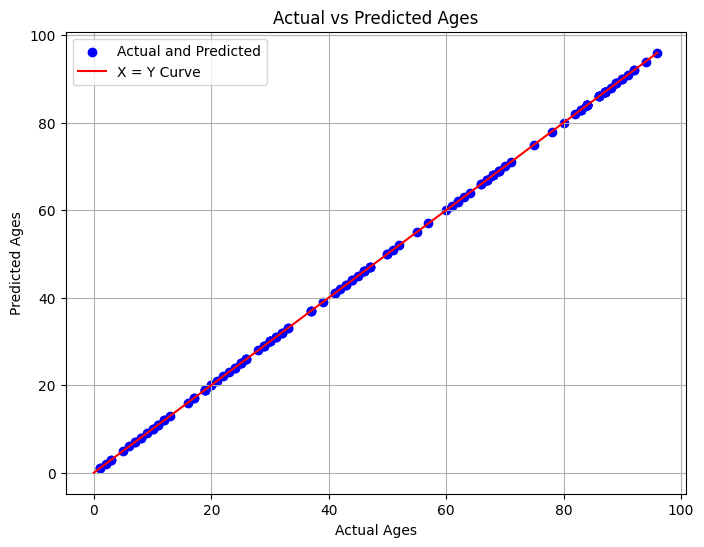

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y, predicted_ages, color='blue', label='Actual and Predicted')
plt.plot([0, max(y)], [0, max(y)], color='red', linestyle='-', label='X = Y Curve')
plt.title('Actual vs Predicted Ages')
plt.xlabel('Actual Ages')
plt.ylabel('Predicted Ages')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


fig = make_subplots()
# Add scatter plot for actual vs predicted ages
fig.add_trace(go.Scatter(x=y, y=predicted_ages, mode='markers', name='Actual and Predicted', marker=dict(color='blue')), row=1, col=1)

# Add diagonal line x=y
fig.add_trace(go.Scatter(x=[min(y), max(y)], y=[min(y), max(y)], mode='lines', name='X = Y Curve', line=dict(color='red')), row=1, col=1)

# Update layout
fig.update_layout(
    title='Actual vs Predicted Ages',
    xaxis_title='Actual Ages',
    yaxis_title='Predicted Ages',
    showlegend=True,
)

# Show the plot
fig.show()